# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline

In [3]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns

In [4]:
from icecream import ic

In [5]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [6]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.datamodules import STL10DataModule

In [7]:
from models import ResnetModule

In [8]:
from dropblock import DropBlock2D, LinearScheduler

In [23]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_ds_split
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_transform
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_train_split
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_test_split
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier
from ls_ood_detect_cea.metrics import get_ood_detector_results, plot_roc_ood_detector

# Load Entropy

In [12]:
gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np.npy')
gtsrb_rn18_l30conv1_h_z_gtsrb_normal_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_l30conv1_h_z_gtsrb_normal_test_samples_np.npy')
gtsrb_rn18_l30conv1_h_z_cifar10_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_l30conv1_h_z_cifar10_valid_samples_np.npy')
gtsrb_rn18_l30conv1_h_z_cifar10_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_l30conv1_h_z_cifar10_test_samples_np.npy')
gtsrb_rn18_l30conv1_h_z_stl10_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_l30conv1_h_z_stl10_valid_samples_np.npy')
gtsrb_rn18_l30conv1_h_z_stl10_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_l30conv1_h_z_stl10_test_samples_np.npy')

In [13]:
ic(gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_l30conv1_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_l30conv1_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_l30conv1_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_l30conv1_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_l30conv1_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 256)
ic| gtsrb_rn18_l30conv1_h_z_gtsrb_normal_test_samples_np.shape: (1273, 256)
ic| gtsrb_rn18_l30conv1_h_z_cifar10_valid_samples_np.shape: (10000, 256)
ic| gtsrb_rn18_l30conv1_h_z_cifar10_test_samples_np.shape: (10000, 256)
ic| gtsrb_rn18_l30conv1_h_z_stl10_valid_samples_np.shape: (1000, 256)
ic| gtsrb_rn18_l30conv1_h_z_stl10_test_samples_np.shape: (8000, 256)


# Build ResNet18 GTSRB Dataset Shift Detector

## Train Dataset 1: gtsrb-valid vs cifar10-valid

In [18]:
(h_train_gtsrb_normal_valid_cifar10_valid,
 labels_h_train_gtsrb_normal_valid_cifar10_valid,
 h_test_gtsrb_normal_test_cifar10_test,
 labels_h_test_gtsrb_normal_test_cifar10_test, _) = build_ood_detection_ds(gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np,  # reference for training set
                                                                             gtsrb_rn18_l30conv1_h_z_cifar10_valid_samples_np,  # reference for training set
                                                                             gtsrb_rn18_l30conv1_h_z_gtsrb_normal_test_samples_np,
                                                                             gtsrb_rn18_l30conv1_h_z_cifar10_test_samples_np)

Train Dataset Samples shape:  (13609, 16)
Train Dataset Labels shape:  (13609,)
Test Dataset Samples shape:  (11273, 16)
Test Dataset Labels shape:  (11273,)


### Test Dataset 1: gtsrb-test & cifar10-test

In [19]:
ic(h_test_gtsrb_normal_test_cifar10_test.shape);
ic(labels_h_test_gtsrb_normal_test_cifar10_test.shape);

ic| h_test_gtsrb_normal_test_cifar10_test.shape: (11273, 16)
ic| labels_h_test_gtsrb_normal_test_cifar10_test.shape: (11273,)


### Test Dataset 2: gtsrb-test & stl10-test

In [24]:
_, _, h_test_gtsrb_normal_test_stl10_test, labels_h_test_gtsrb_normal_test_stl10_test, _ = build_ood_detection_ds(gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np,  # reference for training set
                                                                                                                  gtsrb_rn18_l30conv1_h_z_cifar10_valid_samples_np,  # reference for training set
                                                                                                                  gtsrb_rn18_l30conv1_h_z_gtsrb_normal_test_samples_np,
                                                                                                                  gtsrb_rn18_l30conv1_h_z_stl10_test_samples_np)

Train Dataset Samples shape:  (13609, 16)
Train Dataset Labels shape:  (13609,)
Test Dataset Samples shape:  (9273, 16)
Test Dataset Labels shape:  (9273,)


## Train Model Dataset 1: gtsrb-normal-valid & cifar10-valid

In [20]:
resnet18_gtsrb_h_z_odd_detector_1 = KDEClassifier(bandwidth=0.8)
resnet18_gtsrb_h_z_odd_detector_1.fit(h_train_gtsrb_normal_valid_cifar10_valid, labels_h_train_gtsrb_normal_valid_cifar10_valid)

KDEClassifier(bandwidth=0.8)

## Results Test Dataset 1

In [21]:
resnet18_gtsrb_h_z_odd_detector_1_results_test_ds_1 = get_ood_detector_results("resnet18 detector 1: test ds 1",
                                                                         resnet18_gtsrb_h_z_odd_detector_1,
                                                                         h_test_gtsrb_normal_test_cifar10_test,
                                                                         labels_h_test_gtsrb_normal_test_cifar10_test)

resnet18_gtsrb_h_z_odd_detector_1_results_test_ds_1
print("AUROC: {:0.4f}".format(resnet18_gtsrb_h_z_odd_detector_1_results_test_ds_1['auc'][0].item()))
print("FPR95: {:0.4f}".format(resnet18_gtsrb_h_z_odd_detector_1_results_test_ds_1['fpr@95'][0].item()))
print("F1: {:0.4f}".format(resnet18_gtsrb_h_z_odd_detector_1_results_test_ds_1['f1'][0].item()))

resnet18 detector 1: test ds 1
AUROC: 0.9522
FPR95: 0.2841
F1: 0.7680


resnet18 detector 1: test ds 1


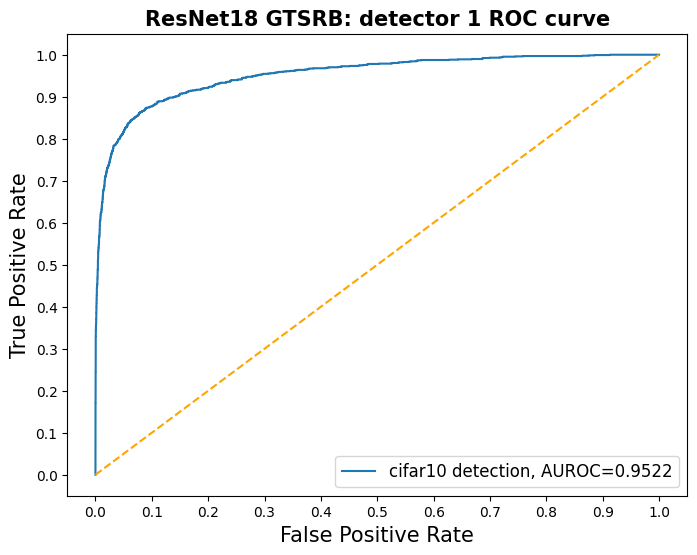

In [28]:
plot_roc_ood_detector(resnet18_gtsrb_h_z_odd_detector_1_results_test_ds_1,
                      "cifar10 detection",
                      "ResNet18 GTSRB: detector 1 ROC curve")

## Results Test Dataset 2
gtsrb-test vs. stl10-test

In [25]:
resnet18_gtsrb_h_z_odd_detector_1_results_test_ds_2 = get_ood_detector_results("resnet18 detector 1: test ds 2",
                                                                               resnet18_gtsrb_h_z_odd_detector_1,
                                                                               h_test_gtsrb_normal_test_stl10_test,
                                                                               labels_h_test_gtsrb_normal_test_stl10_test)

resnet18_gtsrb_h_z_odd_detector_1_results_test_ds_2
print("AUROC: {:0.4f}".format(resnet18_gtsrb_h_z_odd_detector_1_results_test_ds_2['auc'][0].item()))
print("FPR95: {:0.4f}".format(resnet18_gtsrb_h_z_odd_detector_1_results_test_ds_2['fpr@95'][0].item()))
print("F1: {:0.4f}".format(resnet18_gtsrb_h_z_odd_detector_1_results_test_ds_2['f1'][0].item()))

resnet18 detector 1: test ds 2
AUROC: 0.9216
FPR95: 0.4072
F1: 0.6862


resnet18 detector 1: test ds 2


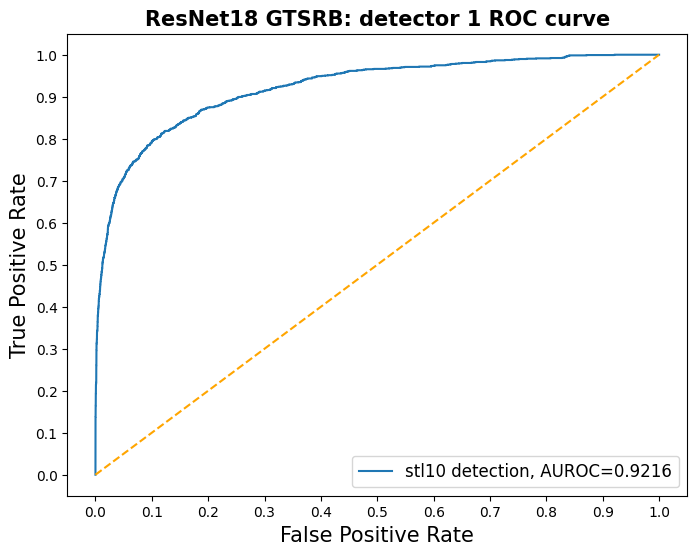

In [27]:
plot_roc_ood_detector(resnet18_gtsrb_h_z_odd_detector_1_results_test_ds_2,
                      "stl10 detection",
                      "ResNet18 GTSRB: detector 1 ROC curve")

## Train Dataset 2: gtsrb-valid & stl10-valid

Train dataset set with sample imbalance:

- __InD/Normal__: ws-normal-valid (1482 samples)
- __OoD/Anomaly__: cs-normal-valid (500 samples)

In [29]:
(h_train_gtsrb_normal_valid_stl10_valid,
labels_h_train_gtsrb_normal_valid_stl10_valid,
h_test_gtsrb_normal_test_stl10_test,
labels_h_test_gtsrb_normal_test_stl10_test, _) = build_ood_detection_ds(gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np,  # reference for training set
                                                                        gtsrb_rn18_l30conv1_h_z_stl10_valid_samples_np,  # reference for training set
                                                                        gtsrb_rn18_l30conv1_h_z_gtsrb_normal_test_samples_np,
                                                                        gtsrb_rn18_l30conv1_h_z_stl10_test_samples_np)

Train Dataset Samples shape:  (4609, 16)
Train Dataset Labels shape:  (4609,)
Test Dataset Samples shape:  (9273, 16)
Test Dataset Labels shape:  (9273,)


### Test Dataset 1: gtsrb-test & stl10-test

In [30]:
ic(h_test_gtsrb_normal_test_stl10_test.shape);
ic(labels_h_test_gtsrb_normal_test_stl10_test.shape);

ic| h_test_gtsrb_normal_test_stl10_test.shape: (9273, 16)
ic| labels_h_test_gtsrb_normal_test_stl10_test.shape: (9273,)


### Test Dataset 2: ws-normal-test & ws-anomal-test

In [31]:
_, _, h_test_gtsrb_normal_test_cifar10_test, labels_h_test_gtsrb_normal_test_cifar10_test, _ = build_ood_detection_ds(gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np,  # reference for training set
                                                                                                                      gtsrb_rn18_l30conv1_h_z_stl10_valid_samples_np,  # reference for training set
                                                                                                                      gtsrb_rn18_l30conv1_h_z_gtsrb_normal_test_samples_np,
                                                                                                                      gtsrb_rn18_l30conv1_h_z_cifar10_test_samples_np)

Train Dataset Samples shape:  (4609, 16)
Train Dataset Labels shape:  (4609,)
Test Dataset Samples shape:  (11273, 16)
Test Dataset Labels shape:  (11273,)


## Train Model Dataset 2: gtsrb-valid & stl10-valid

In [32]:
resnet18_gtsrb_h_z_odd_detector_2 = KDEClassifier(bandwidth=0.8)
resnet18_gtsrb_h_z_odd_detector_2.fit(h_train_gtsrb_normal_valid_stl10_valid, labels_h_train_gtsrb_normal_valid_stl10_valid)

KDEClassifier(bandwidth=0.8)

## Results Test Dataset 1

In [33]:
resnet18_gtsrb_h_z_odd_detector_2_results_test_ds_1 = get_ood_detector_results("resnet18 detector 1: test ds 1",
                                                                               resnet18_gtsrb_h_z_odd_detector_2,
                                                                               h_test_gtsrb_normal_test_stl10_test,
                                                                               labels_h_test_gtsrb_normal_test_stl10_test)

resnet18_gtsrb_h_z_odd_detector_2_results_test_ds_1
print("AUROC: {:0.4f}".format(resnet18_gtsrb_h_z_odd_detector_2_results_test_ds_1['auc'][0].item()))
print("FPR95: {:0.4f}".format(resnet18_gtsrb_h_z_odd_detector_2_results_test_ds_1['fpr@95'][0].item()))
print("F1: {:0.4f}".format(resnet18_gtsrb_h_z_odd_detector_2_results_test_ds_1['f1'][0].item()))

resnet18 detector 1: test ds 1
AUROC: 0.9622
FPR95: 0.2159
F1: 0.6913


resnet18 detector 1: test ds 1


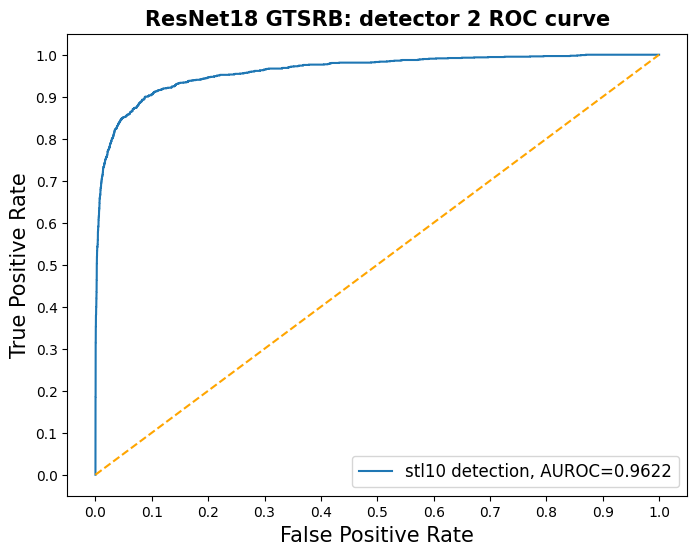

In [34]:
plot_roc_ood_detector(resnet18_gtsrb_h_z_odd_detector_2_results_test_ds_1,
                      "stl10 detection",
                      "ResNet18 GTSRB: detector 2 ROC curve")

## Results Test Dataset 2

In [35]:
resnet18_gtsrb_h_z_odd_detector_2_results_test_ds_2 = get_ood_detector_results("dlv3p-ws detector 2: test ds 2",
                                                                               resnet18_gtsrb_h_z_odd_detector_2,
                                                                               h_test_gtsrb_normal_test_cifar10_test,
                                                                               labels_h_test_gtsrb_normal_test_cifar10_test)

resnet18_gtsrb_h_z_odd_detector_2_results_test_ds_2
print("AUROC: {:0.4f}".format(resnet18_gtsrb_h_z_odd_detector_2_results_test_ds_2['auc'][0].item()))
print("FPR95: {:0.4f}".format(resnet18_gtsrb_h_z_odd_detector_2_results_test_ds_2['fpr@95'][0].item()))
print("F1: {:0.4f}".format(resnet18_gtsrb_h_z_odd_detector_2_results_test_ds_2['f1'][0].item()))

dlv3p-ws detector 2: test ds 2
AUROC: 0.9591
FPR95: 0.2431
F1: 0.6231


dlv3p-ws detector 2: test ds 2


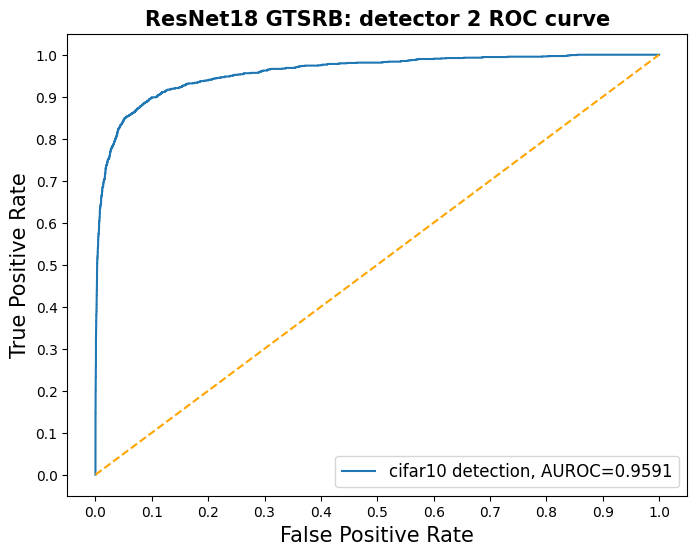

In [36]:
plot_roc_ood_detector(resnet18_gtsrb_h_z_odd_detector_2_results_test_ds_2,
                      "cifar10 detection",
                      "ResNet18 GTSRB: detector 2 ROC curve")

# Build ResNet18 GTSRB Shift Detector, Single KDE

In [63]:
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_auc_score
import pacmap

## Build ResNet18 Single KDE (Only Ind entropy)

In [16]:
gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np.shape

(3609, 256)

In [25]:
hz_train_gtsrb_normal_valid, pca_tr = apply_pca_ds_split(gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np)

ic(hz_train_gtsrb_normal_valid.shape);
ic(pca_tr);

ic| hz_train_gtsrb_normal_valid.shape: (3609, 16)
ic| pca_tr: PCA(n_components=16, svd_solver='randomized', whiten=True)


In [29]:
hz_model = KernelDensity(bandwidth=0.8, kernel='gaussian').fit(hz_train_gtsrb_normal_valid)

In [31]:
hz_model

KernelDensity(bandwidth=0.8)

In [48]:
samples, labels = build_ood_detection_test_split(gtsrb_rn18_l30conv1_h_z_gtsrb_normal_test_samples_np,
                                                 gtsrb_rn18_l30conv1_h_z_cifar10_test_samples_np,
                                                 pca_tr)

Dataset Samples shape:  (11273, 16)
Dataset Labels shape:  (11273,)


In [49]:
scores = hz_model.score_samples(samples)
ic(scores.shape);

ic| scores.shape: (11273,)


In [50]:
auroc = roc_auc_score(labels, scores    )
ic(auroc);

ic| auroc: 0.6003132757266301


## Build ResNet18 Single KDE (Entropy Pacpmap)

In [73]:
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0)
samples_transformed = embedding.fit_transform(gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np, init="pca")
ic(samples_transformed.shape);

ic| samples_transformed.shape: (3609, 2)


In [74]:
samples_cifar10_val = embedding.transform(gtsrb_rn18_l30conv1_h_z_cifar10_valid_samples_np, basis=gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np)
ic(samples_cifar10_val.shape);

ic| samples_cifar10_val.shape: (10000, 2)


In [75]:
samples_stl10_val = embedding.transform(gtsrb_rn18_l30conv1_h_z_stl10_valid_samples_np, basis=gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np)
ic(samples_stl10_val.shape);

ic| samples_cifar10_val.shape: (10000, 2)


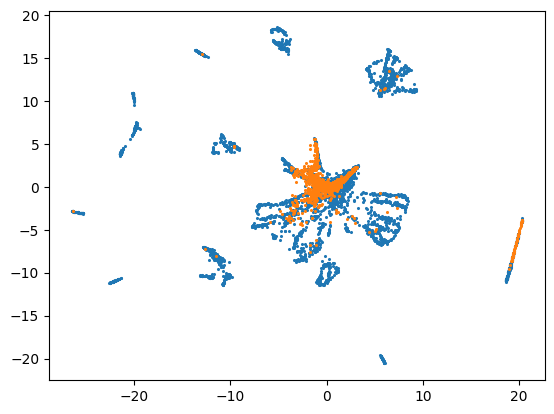

In [81]:
plt.scatter(samples_transformed[:, 0], samples_transformed[:, 1], cmap="brg", s=1.5)
# plt.scatter(samples_cifar10_val[:, 0], samples_cifar10_val[:, 1], cmap="brg", s=1.5)
plt.scatter(samples_stl10_val[:, 0], samples_stl10_val[:, 1], cmap="brg", s=1.5)
plt.show()

## Build ResNet18 Single KDE (Entropy PCA with Ind and OoD samples)

In [52]:
samples, labels, pca_tr = build_ood_detection_train_split(gtsrb_rn18_l30conv1_h_z_gtsrb_normal_valid_samples_np,  # reference for training set
                                                          gtsrb_rn18_l30conv1_h_z_stl10_valid_samples_np)


Dataset Samples shape:  (4609, 16)
Dataset Labels shape:  (4609,)


In [53]:
test_samples, test_labels = build_ood_detection_test_split(gtsrb_rn18_l30conv1_h_z_gtsrb_normal_test_samples_np,
                                                           gtsrb_rn18_l30conv1_h_z_stl10_test_samples_np,
                                                           pca_tr)

Dataset Samples shape:  (9273, 16)
Dataset Labels shape:  (9273,)


In [54]:
h_z_odd_detector = KDEClassifier(bandwidth=0.8)
h_z_odd_detector.fit(samples, labels)

KDEClassifier(bandwidth=0.8)

In [55]:
h_z_odd_detector.models_

[KernelDensity(bandwidth=0.8), KernelDensity(bandwidth=0.8)]

In [61]:
scores = h_z_odd_detector.models_[1].score_samples(test_samples)
ic(scores.shape);

ic| scores.shape: (9273,)


In [62]:
auroc = roc_auc_score(test_labels, scores)
ic(auroc);

ic| auroc: 0.6604854673998428
